In [ ]:
# Imports
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from skimage import io
from torch.utils.data import Dataset, DataLoader # Gives easier dataset managment and creates mini batches

from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

from google.colab import files
from torchsummary import summary

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

# Set Tensorboard output
# writer = SummaryWriter()

# Load the TensorBoard notebook extension
# %load_ext tensorboard

!nvidia-smi

Thu Jun 25 03:55:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install discord-webhook
!pip install livelossplot --quiet
!pip install pytorch-msssim

In [ ]:
from system_info import get_vram_usage
from logging_remote import send_message, send_image, send_file, plot_to_img
from download import download_file
from preprocessing import convert_h5_to_images_on_batch
from dataset import NYUv2
from model_parts import DoubleConv, Up, Down, OutConv
from prediction import predict_single_image
from training_helpers import image_from_gpu, random_hyperparameter_dict, stack_images_h, stack_images_v


send_message("Starting execution of notebook")
"GPU usage: "+str(get_vram_usage())+ " Mb"

'GPU usage: 10.0 Mb'

In [ ]:
!pip install skimage numpy h5py
from tqdm.notebook import tqdm
import skimage.io as io
import numpy as np
import h5py
import sys
import os

!rm -rf "/content/dataset/colors/" # remove later
!rm -rf "/content/dataset/normals/" # remove later

!mkdir -p "/content/dataset/colors/"
!mkdir -p "/content/dataset/normals/"

ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


Output shape: (427, 561, 3)
Example image:


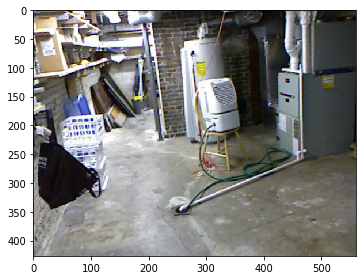


Processed 300 images


Output shape: (427, 561, 3)
Example image:


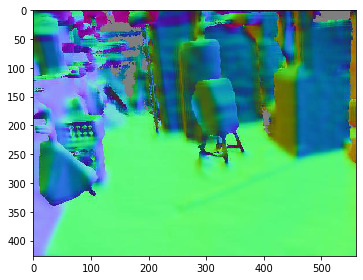


Processed 300 images


Output shape: (427, 561, 3)
Example image:


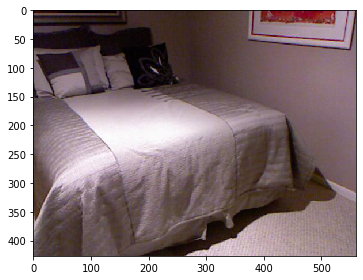


Processed 300 images


Output shape: (427, 561, 3)
Example image:


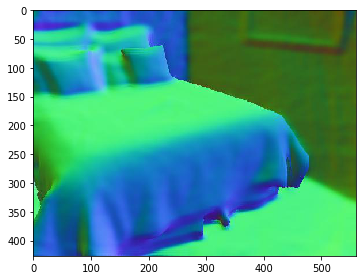


Processed 300 images


Output shape: (427, 561, 3)
Example image:


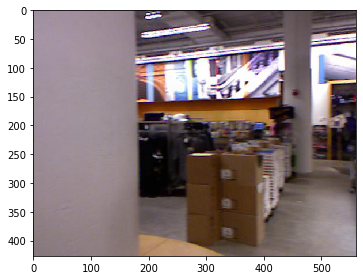


Processed 300 images


Output shape: (427, 561, 3)
Example image:


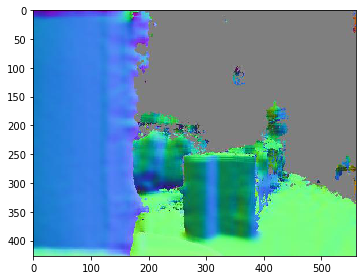


Processed 300 images


''

In [ ]:
import time

!mkdir -p "/content/dataset"
path_to_dataset = "/content/dataset"

start = time.time()
send_message("Downloading dataset...")

# !wget http://horatio.cs.nyu.edu/mit/silberman/rmrc2014//dataset_rgb2normal_train_part1_of_14.mat -P "/content/dataset"
# !wget http://horatio.cs.nyu.edu/mit/silberman/rmrc2014//dataset_rgb2normal_train_part2_of_14.mat -P "/content/dataset"
# !wget http://horatio.cs.nyu.edu/mit/silberman/rmrc2014//dataset_rgb2normal_train_part3_of_14.mat -P "/content/dataset"
# !wget http://horatio.cs.nyu.edu/mit/silberman/rmrc2014//dataset_rgb2normal_train_part11_of_14.mat -P "/content/dataset"
# !wget http://horatio.cs.nyu.edu/mit/silberman/rmrc2014//dataset_rgb2normal_train_part12_of_14.mat -P "/content/dataset"
# !wget http://horatio.cs.nyu.edu/mit/silberman/rmrc2014//dataset_rgb2normal_train_part13_of_14.mat -P "/content/dataset"

parts_to_download = [1,2,3,11,12,13]
parts_to_download = [1,2,3]
# parts_to_download = [1]

for idx, part in enumerate(parts_to_download):
    depth_original = download_file("http://horatio.cs.nyu.edu/mit/silberman/rmrc2014//dataset_rgb2normal_train_part{}_of_14.mat".format(part), path_to_dataset)
    depth_original_path = os.path.join(path_to_dataset, depth_original)

    send_message("Converting images from hdf5 to folder, part {}".format(part))
    convert_h5_to_images_on_batch(depth_original_path,"images","/content/dataset/colors/", prefix=str(idx))
    send_message("Converting normals from hdf5 to folder, part {}".format(part))
    convert_h5_to_images_on_batch(depth_original_path,"normals","/content/dataset/normals/", prefix=str(idx))

end = time.time()

send_message("Completed conversion, took {} hours".format((end - start)/3600))


In [ ]:
preprocess = transforms.Compose([
                # transforms.ToPILImage(),
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

# train_dataset = NYUv2(f, "images", "normals", transform=preprocess)
train_dataset = NYUv2("/content/dataset/colors/", "/content/dataset/normals/", transform=preprocess)

# kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
test_split = 0.3
total_samples = len(train_dataset)
print([int(total_samples * test_split), int(total_samples * (1-test_split))])
print(total_samples)

train_set, test_set = torch.utils.data.random_split(train_dataset, [int(total_samples * test_split), int(total_samples * (1-test_split))])

# # test_loader = DataLoader(valid_dataset, batch_size=Test_Batch_Size, shuffle=False, **kwargs)

Loading color images...
Found 900 images.
Loading normal images...
Found 900 images.
[270, 630]
900


In [ ]:
epoch = 0
num_epochs = 5500

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        # self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        # self.outc = OutConv(64, n_classes)

        self.uconv = nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1)
        self.resize = nn.Upsample(size=(224, 224), mode='bilinear',align_corners=False) # this is to assure the image does not approximate to 223

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.uconv(x)
        return self.resize(x)
        # logits = self.outc(x)
        # return logits


model = UNet(3,0).to(device)

if torch.cuda.is_available():
    summary(model.cuda(), (3, 224, 224))
else:
    summary(model, (3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
        DoubleConv-7         [-1, 32, 224, 224]               0
         MaxPool2d-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]          18,496
      BatchNorm2d-10         [-1, 64, 112, 112]             128
             ReLU-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,928
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

In [ ]:
# pip3 install scikit-image torch torchvision
import torch
import torchvision.transforms as transforms
import skimage.io as io

preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
            ])

In [ ]:

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM


In [ ]:
from livelossplot import PlotLosses

import matplotlib
import matplotlib.pyplot as plt

from ipywidgets import Output
OUTPUT_CONTEXT = Output()
display(OUTPUT_CONTEXT)

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))

!mkdir -p "/content/checkpoints/"

# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 16
batch_size = 32
# batch_size = 128
batch_size = 64
# batch_size = 1

# train_set, test_set = torch.utils.data.random_split(dataset, [5, 5])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

# Loss and optimizer
# criterion = nn.SmoothL1Loss(reduction='sum')
# criterion = nn.MSELoss(reduction="sum")
criterion = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=True, channel=1)

color_data = 0
normal_data = 0

def train(model, epoch, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, verbose=True)

    ssim_loss = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=True, channel=1)
    # Train Network
    with tqdm(total=num_epochs, file=sys.stdout) as epoch_bar:
        liveloss = PlotLosses()
        logs = {}
        losses = []
        send_message("Starting training with optimizer {} for {} epochs with batch_size {} @ {}Mb VRAM usage...".format(optimizer,num_epochs,batch_size,float(get_vram_usage())))

        global color_data # apagar depois
        global normal_data # apagar depois

        for _ in range(num_epochs):
            epoch += 1
            if epoch == 0:
                epoch_bar.set_description(f"Epoch {epoch}")
            for batch_idx, (color_data, normal_data) in enumerate(train_loader):

                batch_losses = []

                # send to gpu
                color_data = color_data.to(device=device)
                normal_data = normal_data.to(device=device)
                
                # forward
                color_output = model(color_data)
                
                # loss = criterion(color_output, normal_data)
                loss = 1-ssim(color_output, normal_data)
                losses.append(float(loss.item()))
                
                # backward
                optimizer.zero_grad()
                loss.backward()

                # gradient step
                optimizer.step()

            logs['log loss'] = loss.item()
            logs['vram usage'] = float(get_vram_usage())
            # logs['accuracy'] = epoch_acc.item()

            epoch_bar.set_description(f"Epoch: {epoch+1}" + " Cost: {:.2f}".format(sum(losses)/len(losses)) + "Progress")
            epoch_bar.update(1)

            if epoch % 100 == 0 and epoch >= 100:

                # Unfreeze layers after plateau
                for param in model.parameters():
                    param.requires_grad = True
                
                output_model_filename = "/content/checkpoints/model_epoch_"+str(epoch)+".pth"
                print("saving",output_model_filename)
                torch.save(model, output_model_filename)
                
            # Plotting cool stuff!
            if epoch == 0 or epoch % 250 == 0:
                plt.subplot(1, 3, 1)
                plt.imshow(image_from_gpu(color_data[0]))

                plt.subplot(1, 3, 2)
                plt.imshow(image_from_gpu(normal_data[0]))

                plt.subplot(1, 3, 3)
                plt.imshow(image_from_gpu(color_output[0]))

                fig = matplotlib.pyplot.gcf()
                fig.set_size_inches(18.5, 10.5)
                plt.tight_layout()
                plt.show()

                send_message("@epoch {} and loss {}".format(epoch,sum(losses)/len(losses)))
                send_image(stack_images_h(
                    image_from_gpu(color_data[0], to_send=True),
                    image_from_gpu(normal_data[0], to_send=True),
                    image_from_gpu(color_output[0], to_send=True),
                    ))
            if epoch == num_epochs:
                send_image(plot_to_img(list(losses)))

            with OUTPUT_CONTEXT:
                if epoch != 0 and epoch > 5:
                    liveloss.update(logs)
                    liveloss.send()
            scheduler.step(epoch)

        
        model.train()
        torch.save(model, "model_epoch_"+str(epoch)+".pth")


# for conv_layers in range(1, 20, 5):
# conv_layers = 11

# send_message("Using SmoothL1Loss")
# model = Net(conv_layers=conv_layers, batch_norm=False).to(device)
# send_message("**We will train with {} conv_layers now**".format(conv_layers))
send_message(str(model.__str__()))
# epoch = 0
model.to(device)
try:
    train(model, epoch, num_epochs)
except Exception as e:
    print("Could not train because of", e)
    send_message(str(e))
    raise


!zip -r "/content/checkpoints.zip" "./checkpoints"


try:
    files.download("/content/checkpoints.zip")
except Exception as e:
    print("Could not download because of",e)
    send_message(str(e))
# send_message("Using MSELoss")
# criterion = nn.MSELoss(reduction="sum")

# model = Net(conv_layers=conv_layers, batch_norm=False).to(device)
# send_message("**We will train with {} conv_layers now**".format(conv_layers))
# send_message(str(model.__str__()))
# epoch = 0
# model.to(device)
# train(model)

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Buffered data was truncated after reaching the output size limit.

In [ ]:
!zip -r "/content/checkpoints.zip" "./checkpoints"


try:
    files.download("/content/checkpoints.zip")
except Exception as e:
    print("Could not download because of",e)
    send_message(str(e))


updating: checkpoints/ (stored 0%)
updating: checkpoints/model_epoch_5400.pth (deflated 8%)
updating: checkpoints/model_epoch_800.pth (deflated 8%)
updating: checkpoints/model_epoch_700.pth (deflated 8%)
updating: checkpoints/model_epoch_4300.pth (deflated 8%)
updating: checkpoints/model_epoch_2100.pth (deflated 8%)
updating: checkpoints/model_epoch_1100.pth (deflated 8%)
updating: checkpoints/model_epoch_3800.pth (deflated 8%)
updating: checkpoints/model_epoch_2500.pth (deflated 8%)
updating: checkpoints/model_epoch_5100.pth (deflated 8%)
updating: checkpoints/model_epoch_3600.pth (deflated 8%)
updating: checkpoints/model_epoch_3200.pth (deflated 8%)
updating: checkpoints/model_epoch_2900.pth (deflated 8%)
updating: checkpoints/model_epoch_3000.pth (deflated 8%)
updating: checkpoints/model_epoch_4200.pth (deflated 8%)
updating: checkpoints/model_epoch_200.pth (deflated 8%)
updating: checkpoints/model_epoch_3900.pth (deflated 8%)
updating: checkpoints/model_epoch_4400.pth (deflated 8%)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


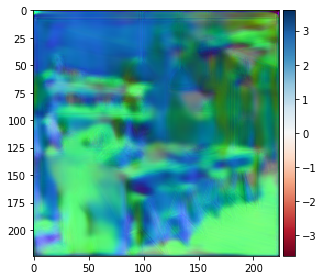

In [ ]:
from PIL import Image
import numpy as np

# files.download("/content/checkpoints/model_epoch_5500.pth")
files.download("/content/checkpoints/model_epoch_2500.pth")
# files.download("/content/checkpoints/model_epoch_4000.pth")

model2 = torch.load("/content/checkpoints/model_epoch_1500.pth")
model2.eval()

download_file("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/white-kitchen-1-1537194316.jpg", output_filename="test.jpg")
test_img = np.array(Image.open("test.jpg"))
result_image = predict_single_image(test_img, model2, preprocess)
io.imshow(test_img)
io.imshow(result_image)

In [ ]:
for batch_idx, (color_data, normal_data) in enumerate(train_loader):
    break

In [ ]:
def predict_single_image(image, model, preprocess):
    if isinstance(image, (np.ndarray, np.generic) ):
        image = Image.fromarray(np.uint8(image))

    if preprocess:
        image = preprocess(image)

    # Reshape to B, C, W, H to feed into network
    if torch.cuda.is_available():
        image = image.cuda()
        image = model(image.view(1,*image.shape)).detach().cpu().numpy()
    else:
        image = model(image.view(1,*image.shape)).detach().numpy()

    # reshape back into original W, H, C image shape
    image = image.reshape(*image.shape[1:]).transpose(1, 2, 0)

    return image


In [ ]:
import torchvision
grid = torchvision.utils.make_grid(
    torch.tensor(np.append(im_nrm,im_col,axis=0))
)

plt.imshow(grid[0])


In [ ]:

# im_nrm = im_nrm.reshape(-1,*im_nrm.shape) # is equivalent to im_nrm = np.expand_dims(im_nrm, axis=0)
# im_col = np.expand_dims(image_from_gpu(color_data[0]), axis=0)
# im_nrm = np.expand_dims(image_from_gpu(normal_data[0]), axis=0)
im_col = image_from_gpu(color_data[0])
im_nrm = image_from_gpu(normal_data[0])
plt.imshow(np.concatenate((im_col, im_nrm), axis=1))

In [ ]:
# !wget https://www.alfab.com.au/wp-content/uploads/2018/10/marinewindows-min1.jpg
import torch
from torch.autograd import Variable
from torch import optim
from PIL import Image
import numpy as np
import sys, os
import torch.nn.functional as F

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
npImg1 = np.array(Image.open("marinewindows-min1.jpg"))

img1 = torch.from_numpy(npImg1).float().view(1,*npImg1.shape)/255.0
img2 = torch.rand(img1.size())

print(img1.shape)

if torch.cuda.is_available():
    img1 = img1.cuda()
    img2 = img2.cuda()

img1 = Variable( img1,  requires_grad=False)
img2 = Variable( img2,  requires_grad=True)

ssim_value = ssim(img1, img2).item()
print("Initial ssim:", ssim_value)